# Part 1: Implementing Simpson's Method

Review: The integral of $f(x)$ within closed interval $x \in [a, b]$ is:

$$
\int^b_a f(x)\ dx \approx \frac{(b-a)}{6}\Big(f(a) + 4f\big(\frac{a+b}{2}\big) +f(b)\Big)

In [39]:
function integrate_simpson(
        f::Function,
        a::Number,
        b::Number,
        n::Number,
        epsilon::Number = 1e-8,
        M::Number = 10000,
    )
    h::Number = (b - a) / n
    I::Number = 0.0  # area
    x::Number = a
    for i in 1:n
        xh = x + h
        I += f(xh - x) / 6 * (f(x) + 4 * f((x + xh) / 2) + f(xh))  # sum all sub-area
        x += h
    end
    I *= h
    error::Number = abs(I)

    j::Number = 1
    while j < M && error < epsilon * abs(I)
        n *= 2
        h = (b - a) / n
        Itemp::Number = I
        x = a
        for j in 1:n
            xh = x + h
            Itemp += f(h) / 6 * (f(x) + 4 * f((x + xh) / 2) + f(xh))  # sum all sub-area
            x += h
        end
        I *= h
        error = abs(I - Itemp)
    end

    return I
end 

integrate_simpson (generic function with 3 methods)

Test

# Part 2: Case-study

> 
> The following codes and reports referenced from the following resources:
> 
> - https://github.com/tensorflow/probability
> - https://www.youtube.com/watch?v=BrwKURU-wpk
> - https://towardsdatascience.com/how-to-use-bayesian-inference-for-predictions-in-python-4de5d0bc84f3
> - https://en.wikipedia.org/wiki/Posterior_predictive_distribution
> - https://www.dagstuhl.de/en/seminars/seminar-calendar/seminar-details/21432
> 

## Import UCI Iris dataset

In [3]:
using CSV, DataFrames, Distributions, Plots, Query, Random, Statistics

path = "iris/iris.data"
iris_names = [
    "sepal_length", "sepal_width", "petal_length", "petal_width", "class"
]
df = CSV.read(
    path,
    header=[
        "sepal_length", "sepal_width", "petal_length", "petal_width", "class"
    ],
    copycols=true,
    DataFrame,
)

# df = DataFrame(csv_data, Symbol.(iris_names))
dropmissing!(df)

Row,sepal_length,sepal_width,petal_length,petal_width,class
,Float64,Float64,Float64,Float64,String15
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa


In [4]:
classes = unique(String.(df[!, :class]))

3-element Vector{String}:
 "Iris-setosa"
 "Iris-versicolor"
 "Iris-virginica"

In [5]:
cat_df = Dict{String, Any}()
for cls in classes
    println(cls)
    cat_df[cls] = @from i in df begin
                  @where i.class == cls
                  @select {
                      i.sepal_length,
                      i.sepal_width,
                      i.petal_length,
                      i.petal_width,
                      i.class,
                  }
                  @collect DataFrame
    end
end

cat_df["Iris-setosa"]

Iris-setosa


Iris-versicolor
Iris-virginica


Row,sepal_length,sepal_width,petal_length,petal_width,class
,Float64,Float64,Float64,Float64,String15
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa


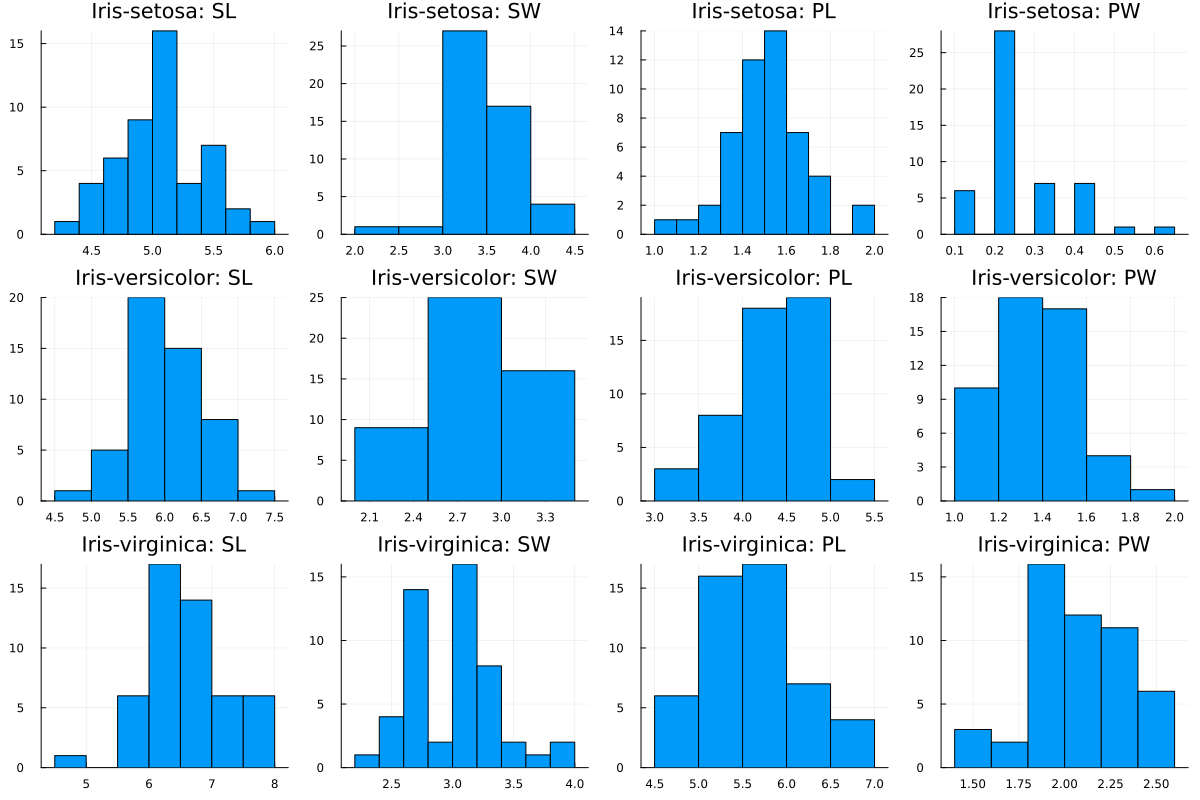

In [6]:
histogram(
    [
        cat_df["Iris-setosa"][!, "sepal_length"],
        cat_df["Iris-setosa"][!, "sepal_width"],
        cat_df["Iris-setosa"][!, "petal_length"],
        cat_df["Iris-setosa"][!, "petal_width"],
        cat_df["Iris-versicolor"][!, "sepal_length"],
        cat_df["Iris-versicolor"][!, "sepal_width"],
        cat_df["Iris-versicolor"][!, "petal_length"],
        cat_df["Iris-versicolor"][!, "petal_width"],
        cat_df["Iris-virginica"][!, "sepal_length"],
        cat_df["Iris-virginica"][!, "sepal_width"],
        cat_df["Iris-virginica"][!, "petal_length"],
        cat_df["Iris-virginica"][!, "petal_width"],
    ],
    title=["Iris-setosa: SL" "Iris-setosa: SW" "Iris-setosa: PL" "Iris-setosa: PW" "Iris-versicolor: SL" "Iris-versicolor: SW" "Iris-versicolor: PL" "Iris-versicolor: PW" "Iris-virginica: SL" "Iris-virginica: SW" "Iris-virginica: PL" "Iris-virginica: PW"],
    label=nothing,
    layout=(3, 4),
    size=(1200, 800),
)

## Feature Selection

For the sake of our demonstration, I will only perform on petal width.

In [7]:
pw_data = df[!, "petal_width"]

150-element Vector{Float64}:
 0.2
 0.2
 0.2
 0.2
 0.2
 0.4
 0.3
 0.2
 0.2
 0.1
 ⋮
 2.3
 1.9
 2.3
 2.5
 2.3
 1.9
 2.0
 2.3
 1.8

# Infer Mean and Standard Deviation, Assuming the Normal Distribution

For the sake of our demonstration, I will only perform on `Iris-versicolor`.

In [8]:
μ = Dict()
σ = Dict()

for cls in classes
    μ[cls] = mean(cat_df[cls][!, "petal_width"])
    σ[cls] = std(cat_df[cls][!, "petal_width"])
end

σ["Iris-versicolor"]

0.19775268000454405

In [9]:
μ["Iris-versicolor"]

1.3259999999999998

In [10]:
Random.seed!(69)

TaskLocalRNG()

In [11]:
σ["Iris-versicolor"]

0.19775268000454405

In [12]:
norm_versicolor = Normal(μ["Iris-versicolor"], σ["Iris-versicolor"])

Normal{Float64}(μ=1.3259999999999998, σ=0.19775268000454405)

## Calculate prior, likelihood, evidence, posterior

In [13]:
n = 300
mu = Vector(LinRange(0.0, 5.5, n))

300-element Vector{Float64}:
 0.0
 0.018394648829431436
 0.03678929765886287
 0.05518394648829432
 0.07357859531772575
 0.09197324414715718
 0.11036789297658864
 0.12876254180602006
 0.1471571906354515
 0.16555183946488294
 ⋮
 5.352842809364549
 5.37123745819398
 5.389632107023411
 5.408026755852843
 5.426421404682275
 5.444816053511706
 5.463210702341137
 5.481605351170568
 5.5

In [14]:
prior = [
    pdf(norm_versicolor, m) for m in mu
]
prior = prior / sum(prior)  # normalize so that it sum up to 1.0

300-element Vector{Float64}:
 6.399997128757547e-12
 1.1889934309075014e-11
 2.1898855974128552e-11
 3.9985791353147174e-11
 7.238228012732214e-11
 1.298975979219115e-10
 2.3110656180589823e-10
 4.076296153383283e-10
 7.127898022238797e-10
 1.235661519818206e-9
 ⋮
 3.3788475761880396e-92
 5.061467306860387e-93
 7.516688749422164e-94
 1.1066721857265612e-94
 1.6153019538866502e-95
 2.337387612282713e-96
 3.3531273941981497e-97
 4.7688280742067975e-98
 6.723812177750596e-99

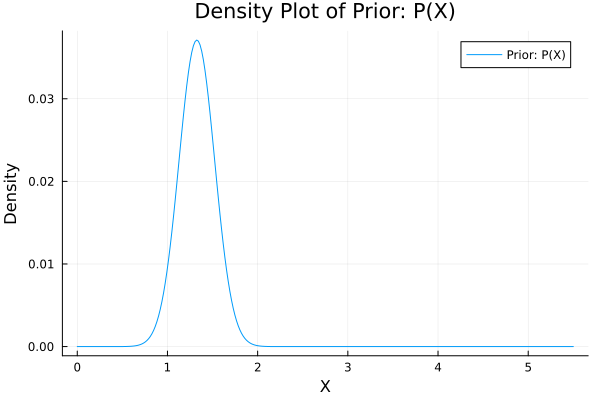

In [15]:
plot(mu, prior, label="Prior: P(X)", title="Density Plot of Prior: P(X)", xlabel="X", ylabel="Density")

The plot shows that `Iris-versicolor` $X$ lies around $(1, 2)$. We will test if it works when:

* $X = 1.25$ (right in the middle)
* $X = 5.0$ (outlier)

First, let $X = 5.0 \text{ cm}$

In [16]:
datum_mean = 5.0

5.0

In [17]:
likelihood = [
    pdf(Normal(m, σ["Iris-versicolor"]), datum_mean)
    for m in mu
]
likelihood = likelihood / sum(likelihood)

300-element Vector{Float64}:
 5.655174442121849e-141
 5.91533576930768e-140
 6.13415990243306e-139
 6.306277542189072e-138
 6.42737092649908e-137
 6.494353788171761e-136
 6.505502071148511e-135
 6.460527676940122e-134
 6.360590837598159e-133
 6.208250373408031e-132
 ⋮
 0.007591841974951238
 0.006403076850196048
 0.005353928475449136
 0.00443811663937083
 0.003647263620106285
 0.0029715147732584397
 0.002400108797413841
 0.0019218799673981952
 0.0015256815247917462

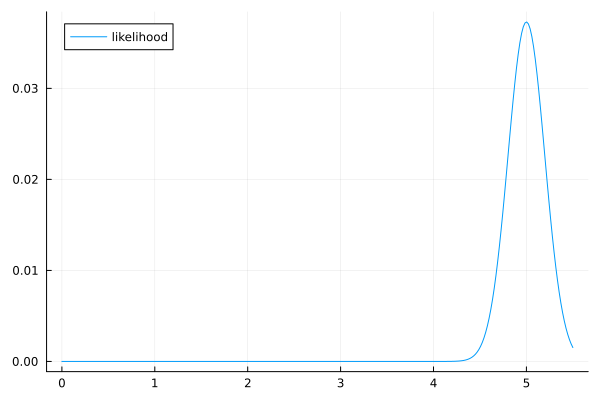

In [18]:
plot(mu, likelihood, label="likelihood")

In [19]:
unnormalized_posterior = likelihood .* prior

300-element Vector{Float64}:
 3.6193100192202897e-152
 7.033295371319002e-151
 1.3433108422565602e-149
 2.5216149801701003e-148
 4.652277628840625e-147
 8.436009571385781e-146
 1.5034642164842824e-144
 2.633502411833726e-143
 4.533764285158613e-142
 7.671296091817312e-141
 ⋮
 2.565167685586661e-94
 3.240896414058188e-95
 4.024381393661948e-96
 4.911540241801937e-97
 5.89143205189738e-98
 6.945581820729351e-99
 8.047870557664327e-100
 9.165115143784157e-101
 1.025839601576384e-101

Implement our numerical integration

In [20]:
function integrate_mp(
    f::Function,
    a::Number,
    b::Number,
    n::Number,
    epsilon::Number = 1e-8,
    M::Number = 10000,
)
    h::Number = (b - a) / n
    I::Number = 0.0  # area
    x::Number = a + h/2
    for i in 1:n
        I += f(x)  # sum all sub-area
        x += h  # change to the next midpoint
    end
    I *= h  # h is the common factor (width along x-axis)
    error::Number = abs(I)

    j::Number = 1
    while j < M && error < epsilon * abs(I)
        n *= 2
        h = (b - a) / n
        Itemp::Number = I
        x = a + h/2
        for j in 1:n
            I += f(x)
            x += h
        end
        I *= h
        error = abs(I - Itemp)
    end
    return I
end 

integrate_mp (generic function with 3 methods)

In [21]:
function f(x)
    idx = convert(Int, floor(1 + (x - minimum(mu)) / maximum(mu) * n))
    return unnormalized_posterior[idx]
end

f (generic function with 1 method)

Here, we use numerical integration to calculate evidence. From Bayes' Theorem:

$$
P(X|\theta) = \frac{P(\theta|X)P(X)}{P(\theta)}
$$

$P(\theta)$ is the evidence here.

In [22]:
evidence = integrate_mp(f, minimum(mu), maximum(mu), n)

1.6142924493350642e-41

In [23]:
posterior = unnormalized_posterior / evidence

300-element Vector{Float64}:
 2.242041100242464e-111
 4.3568904594802845e-110
 8.321359880050713e-109
 1.562055859958192e-107
 2.881929870115494e-106
 5.225824834193221e-105
 9.313456289184574e-104
 1.631366369159739e-102
 2.8085148307706546e-101
 4.752110495825685e-100
 ⋮
 1.5890352994237612e-53
 2.0076265706335498e-54
 2.4929692233396817e-55
 3.0425343585203703e-56
 3.6495444517033404e-57
 4.3025548583779065e-58
 4.985385740346669e-59
 5.677481268997645e-60
 6.354732080912184e-61

In [24]:
function f2(x)
    idx = convert(Int, floor(1 + (x - minimum(mu)) / maximum(mu) * n))
    return posterior[idx]
end
evidence = integrate_mp(f2, minimum(mu), maximum(mu), n)

0.9999999999999992

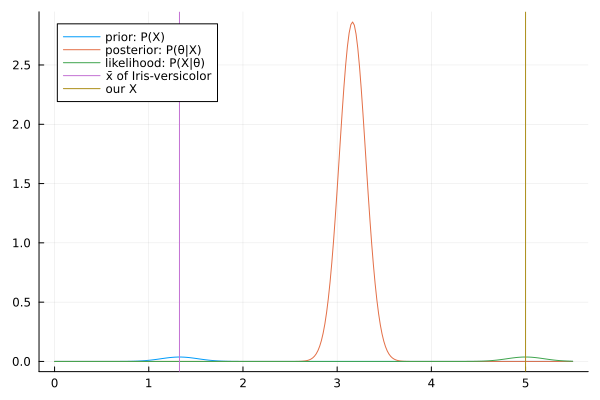

In [25]:
plot(mu, prior, label="prior: P(X)")
plot!(mu, posterior, label="posterior: P(θ|X)")
plot!(mu, likelihood,label="likelihood: P(X|θ)")
vline!([μ["Iris-versicolor"]], label="x̄ of Iris-versicolor")
vline!([datum_mean], label="our X")

If we calculate in terms of probability, given $h = 1.0\times 10^{-8}$, we can use `pdf()` along with `integrate_mp()` to optain the probability we want.

For $X = 5.0$, the probability given `Iris-versicolor` petal-width is

In [26]:
function find_mu_sigma(post, mu)
    mu_idx = argmax(posterior)
    mu_plus_sigma_idx = mu_idx
    while post[mu_idx] - post[mu_plus_sigma_idx] < 0.3413
        println(post[mu_idx] - post[mu_plus_sigma_idx])
        mu_plus_sigma_idx += 1
    end
    return mu[mu_idx], mu[mu_plus_sigma_idx] - mu[mu_idx]  # mean, std
end

find_mu_sigma (generic function with 1 method)

In [27]:
h = 1e-8

# posterior contains the new distribution, we need to recalculate it.
post_mean, post_std = find_mu_sigma(posterior, mu)
post_norm = Normal(post_mean, post_std)

# because pdf has complex definition, I will redefine the simpler one
# so that it works with integrate_mp()
function versicolor_pdf(x)
    return pdf(post_norm, x)
end

println("pdf(X=$datum_mean) = $(versicolor_pdf(datum_mean))")
println("pdf(X=x̄) = $(versicolor_pdf(μ["Iris-versicolor"]))")
println("p(X=$datum_mean) = $(integrate_mp(versicolor_pdf, datum_mean, datum_mean + h, n))")
# also check with the mean value
println("p(X=x̄) = $(integrate_mp(versicolor_pdf, μ["Iris-versicolor"], μ["Iris-versicolor"] + h, n))")

0.0
0.027007969341158233
0.1019476794228793
0.22101497835669992
pdf(X=5.0) = 3.2374329602197025e-135
pdf(X=x̄) = 1.7822104172837365e-135
p(X=5.0) = 3.2374274505929563e-143
p(X=x̄) = 1.7822134315791664e-143


As you can see, $X = 5.0\text{ cm}$ is obviously an outlier, but so $\bar{x}$ because the outlier just went-off too far.

What if $X$ is more likely to be `Iris-versicolor`? Let $X = 1.25 \text{ cm}$ and do everything all over again.

0.0
0.0011842338802217078
0.005147993423412434
0.011875996073483552
0.021342344405105074
0.03351069219281788
0.048334476896152445
0.06575721647974575
0.08571286792069754
0.10812624421894368
0.1329134862263781
0.15998258515212882
0.18923395118994502
0.22056102335302685
0.253850915295732
0.2889850916528933
0.3258400692383949


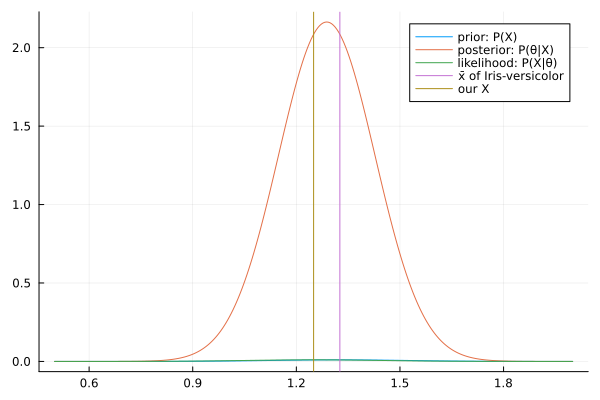

In [28]:
n = 300
mu = Vector(LinRange(0.5, 2.0, n))

datum_mean = 1.25

prior = [
    pdf(norm_versicolor, m) for m in mu
]
prior = prior / sum(prior)  # normalize so that it sum up to 1.0

likelihood = [
    pdf(Normal(m, σ["Iris-versicolor"]), datum_mean)
    for m in mu
]
likelihood /= sum(likelihood)

unnormalized_posterior = likelihood .* prior
evidence = integrate_mp(f, minimum(mu), maximum(mu), n)
posterior = unnormalized_posterior / evidence

post_mean, post_std = find_mu_sigma(posterior, mu)
post_norm = Normal(post_mean, post_std)

plot(mu, prior, label="prior: P(X)")
plot!(mu, posterior, label="posterior: P(θ|X)")
plot!(mu, likelihood,label="likelihood: P(X|θ)")
vline!([μ["Iris-versicolor"]], label="x̄ of Iris-versicolor")
vline!([datum_mean], label="our X")

Calculate the probability.

In [29]:
println("p(X=$datum_mean) = $(integrate_mp(versicolor_pdf, datum_mean, datum_mean + h, n))")
# also check with the mean value
println("p(X=x̄) = $(integrate_mp(versicolor_pdf, μ["Iris-versicolor"], μ["Iris-versicolor"] + h, n))")

p(X=1.25) = 4.2440086915389726e-8
p(X=x̄) = 4.227429824350467e-8


The special use of numerical integration over Baysian Predictive Posterior is to approximate the probability over a given proportion of bell curve. **Baysian Predictive Posterior has superior advantages when it comes to inference of combination of known data ($\theta$) and new data ($X$).**

Suppose we have 1,000 flowers over normal distribution $F$, denoted as $X \sim N(\mu_F, \sigma_F) = N(1.1, 0.12)$, all of them are classified as `Iris-versicolor` but unknown to the UCI Iris dataset. Given this data is normal, we want to estimate how many of them have petal width longer than $1.2 \text{ cm}$. We can do the same trick using `integrate_mp()`.

0.0
0.011109663470874942
0.034448936014510156
0.06977452441387078
0.11672025229940441
0.17480337877392582
0.24343286122992636
0.3219193646090912


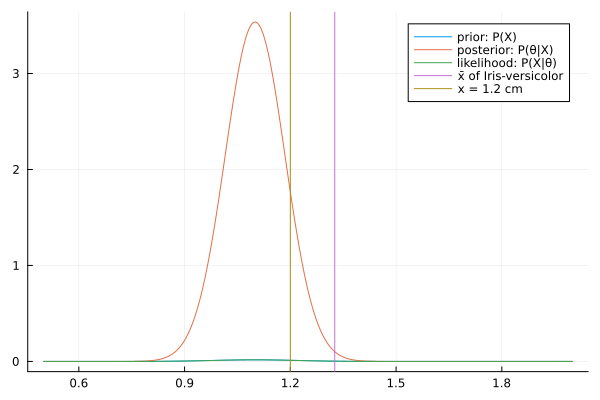

In [30]:
X_norm = Normal(1.1, 0.12)

n = 300
mu = Vector(LinRange(0.5, 2.0, n))

prior = [
    pdf(X_norm, m)
    for m in mu
]
prior = prior / sum(prior)  # normalize so that it sum up to 1.0

likelihood = [
    pdf(Normal(m, X_norm.σ), X_norm.μ)
    for m in mu
]
likelihood /= sum(likelihood)

unnormalized_posterior = likelihood .* prior
evidence = integrate_mp(f, minimum(mu), maximum(mu), n)
posterior = unnormalized_posterior / evidence

post_mean, post_std = find_mu_sigma(posterior, mu)
post_norm = Normal(post_mean, post_std)

plot(mu, prior, label="prior: P(X)")
plot!(mu, posterior, label="posterior: P(θ|X)")
plot!(mu, likelihood,label="likelihood: P(X|θ)")
vline!([μ["Iris-versicolor"]], label="x̄ of Iris-versicolor")
vline!([1.2], label="x = 1.2 cm")

And the probability is the area under posterior within $\mu \in [1.2, \infty)$.

In [31]:
integrate_mp(versicolor_pdf, 1.2, maximum(mu), n)

0.007300729208880859

This mean, the area within $\mu \in [1.2, \infty)$ is 0.73% of the data, or around $7.3 \approx 7$ flowers out of 1000.

What if we calculate the probability from the mean of posterior instead?

In [32]:
post_norm.μ

1.1020066889632107

In [33]:
integrate_mp(versicolor_pdf, post_norm.μ, maximum(mu), n)

0.5000000000000101

Here, the mean value is close to `0.5`, so this one made some sense.